In [31]:
# Core libraries
import numpy as np
import pandas as pd
import os
import inspect
import json
from pathlib import Path
from IPython.display import display, HTML
from typing import Tuple, Optional

# Machine learning
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             balanced_accuracy_score, log_loss,
                             mean_squared_error, make_scorer,
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
from sklearn.inspection import permutation_importance

# Hyperparameter tuning
import optuna
# 1) Silence Optuna’s default trial‐completion logs
optuna.logging.set_verbosity(optuna.logging.WARNING)      # only WARN and above
optuna.logging.disable_default_handler()                   # remove the stderr handler

# Explainability
import shap
try:
    from lime.lime_tabular import LimeTabularExplainer
    _lime_available = True
except ImportError:
    _lime_available = False
    print("Warning: LIME not installed. Run `pip install lime` to enable LIME explanations.")
import lime
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# System
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

class TqdmCallback:
    def __init__(self, total):
        self.bar = tqdm(total=total, desc="Trials", position=2, leave=False)
    def __call__(self, study, trial):
        self.bar.update(1)
    def close(self):
        self.bar.close()

In [32]:
DATA_CSV      = "../data/df_2022_2024.csv"
OUT_DIR       = "../ancillary_models"

TARGETS =  [
    'Price_positive_secondary',
    'Price_negative_secondary',
    'Price_positive_tertiary',
    'Price_negative_tertiary'
]

LABEL_METHOD  = "fixed"         # {"fixed","rolling","dynamic"}
TWO_SIDED     = True              # detect negative spikes too ?
LABEL_MODE    = "binary_extreme"  # or "three_class"

P_HI, P_LO    = 90, 10
ROLL_WINDOW   = 24*7
K_SIGMA       = 2

N_SPLITS      = 5
N_TRIALS      = 40
# N_TRIALS      = 1
EARLY_STOP = 30
GPU_TREE      = True

TH_TOP = 300
TH_BOTTOM = 0

In [ ]:
#Load data
data = pd.read_csv(DATA_CSV)
data.index = pd.date_range(start='2022-11-01', periods=len(data), freq='H')

data = data.loc['2023-01-01':'2023-12-31'].copy()

# Define features
features = [col for col in data.columns if col not in TARGETS]

# Fill missing values
data.fillna(method='ffill', inplace=True)

In [34]:
def global_lag_autocorr(
    df: pd.DataFrame,
    lags: list[int]
) -> pd.Series:
    """
    Compute the **average** lag-correlation across *all* numeric columns
    in `df`, for each lag in `lags`.  Non-numeric columns are automatically dropped.
    """
    # 1) keep only numeric / bool columns
    df_num = df.select_dtypes(include=[np.number, 'bool'])
    
    # 2) for each lag, compute per-column autocorr, then take the mean
    results = {}
    for lag in lags:
        corrs = df_num.apply(lambda s: s.autocorr(lag=lag))
        results[lag] = corrs.mean()
    
    return pd.Series(results)

# --- Usage ---
lags = [1, 2, 3, 4, 24, 168]
# assume `features` is your list of 45 feature names (all numeric)
avg_corrs = global_lag_autocorr(data[features], lags)
print(avg_corrs)

1      0.777011
2      0.648866
3      0.541832
4      0.458291
24     0.515226
168    0.388661
dtype: float64


In [35]:
def per_feature_lag_autocorr(
    df: pd.DataFrame,
    lags: list[int]
) -> pd.DataFrame:
    df_num = df.select_dtypes(include=[np.number, 'bool'])
    records = []
    for lag in lags:
        corrs = df_num.apply(lambda s: s.autocorr(lag=lag))
        for feat, corr in corrs.items():
            records.append({'feature': feat, 'lag': lag, 'autocorr': corr})
    return pd.DataFrame(records)

detail = per_feature_lag_autocorr(data[features], lags)
# e.g. pivot for easy viewing:
pivot = detail.pivot(index='feature', columns='lag', values='autocorr')
print(pivot)

lag                                               1         2         3    \
feature                                                                     
CH_dayahead_price                            0.966280  0.895843  0.813454   
CH_intraday_price                            0.657680  0.565867  0.551216   
Cross_border_physical_flows_AT_CH            0.925623  0.812281  0.698240   
Cross_border_physical_flows_CH_AT            0.851059  0.680424  0.542688   
Cross_border_physical_flows_CH_DE            0.893027  0.687163  0.473861   
Cross_border_physical_flows_CH_FR            0.842267  0.589127  0.366756   
Cross_border_physical_flows_CH_IT            0.921872  0.815959  0.711409   
Cross_border_physical_flows_DE_CH            0.948640  0.861601  0.767530   
Cross_border_physical_flows_FR_CH            0.923853  0.798324  0.678087   
Cross_border_physical_flows_IT_CH            0.832911  0.635333  0.475150   
Energy_negative_secondary                    0.458817  0.240182  0.072479   

In [36]:
selected_lags = [lag for lag, corr in avg_corrs.items() if abs(corr) > 0.5]
print(selected_lags)

[1, 2, 3, 24]


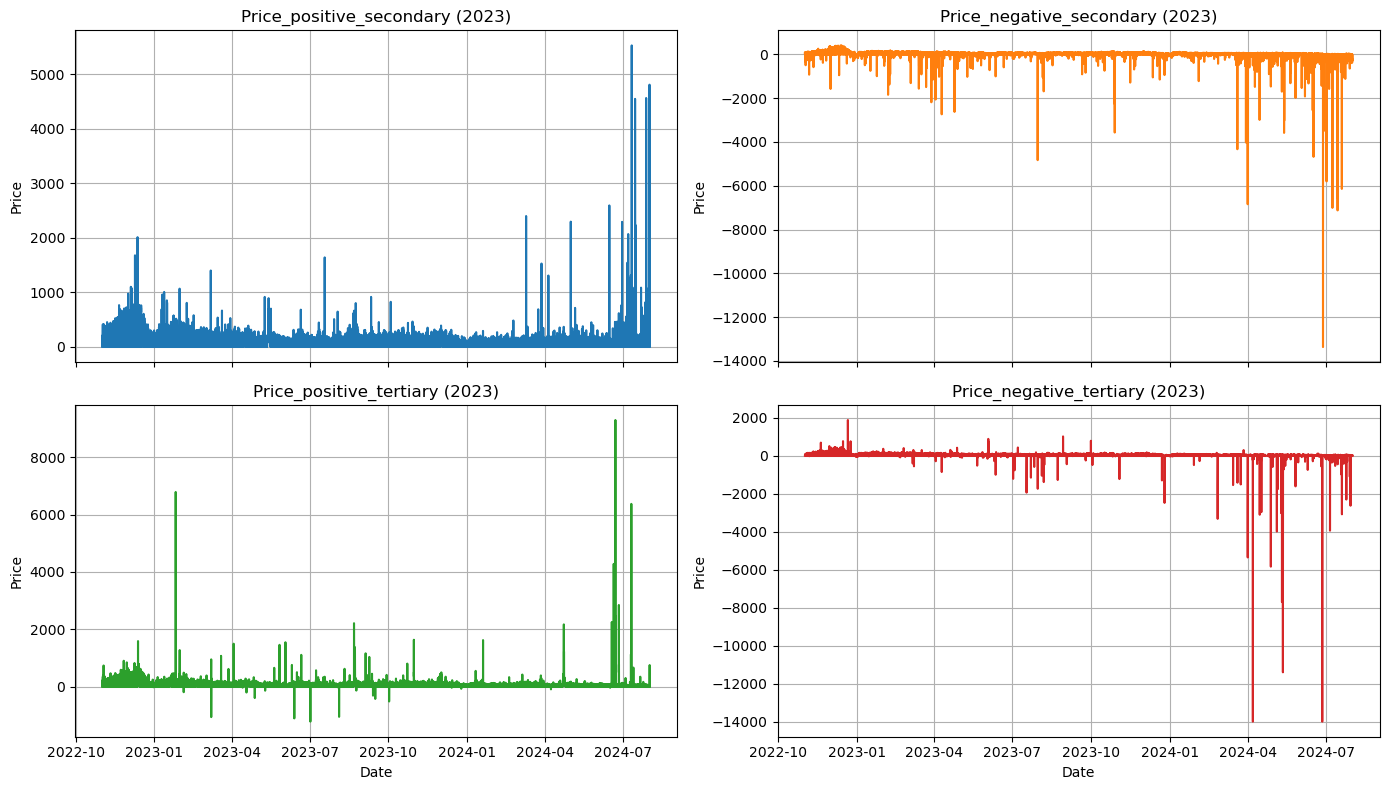

In [50]:
COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), sharex=True)
axes = axes.flatten()

for ax, target, color in zip(axes, TARGETS, COLORS):
    ax.plot(data.index, data[target], color=color)
    ax.set_title(f'{target} (2023)')
    ax.set_ylabel('Price')
    ax.grid(True)

# Set common xlabel
for ax in axes[2:]:
    ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

In [38]:
def make_labels(
    series: pd.Series,
    method: str = LABEL_METHOD,
    two_sided: bool = TWO_SIDED,
    percentile_high: float = P_HI,
    percentile_low: float  = P_LO,
    roll_window: int       = ROLL_WINDOW,
    k: float               = K_SIGMA,
    pos_floor: float       = 100,
    neg_floor: float       = 5.0,
) -> pd.Series:
    """
    Compute hi/lo thresholds for `series` according to `method`,
    then label spikes whenever:
      - series >= hi  AND series >= pos_floor
      OR
      - series <= lo  AND series <= -neg_floor

    Returns a pd.Series of 0/1 labels.
    """
    # 1) compute hi/lo (either scalars or Series)
    if method == "fixed":
        hi = np.percentile(series, percentile_high)
        lo = np.percentile(series, percentile_low) if two_sided else None

    elif method == "rolling":
        hi = series.rolling(roll_window, min_periods=1).quantile(percentile_high/100)
        lo = series.rolling(roll_window, min_periods=1).quantile(percentile_low/100) if two_sided else None

    elif method == "dynamic":
        mu = series.rolling(roll_window, min_periods=1).mean()
        sd = series.rolling(roll_window, min_periods=1).std().fillna(0)
        hi = mu + k * sd
        lo = mu - k * sd if two_sided else None

    elif method == "mixed":
        # fixed
        fixed_hi = np.percentile(series, percentile_high)
        fixed_lo = np.percentile(series, percentile_low) if two_sided else None
        # dynamic
        mu = series.rolling(roll_window, min_periods=1).mean()
        sd = series.rolling(roll_window, min_periods=1).std().fillna(0)
        dyn_hi = mu + k * sd
        dyn_lo = mu - k * sd if two_sided else None
        # combine
        hi = dyn_hi.where(dyn_hi > fixed_hi, fixed_hi)
        lo = dyn_lo.where(dyn_lo < fixed_lo, fixed_lo) if two_sided else None

    else:
        raise ValueError(f"Unknown method: {method}")

    # 2) build boolean mask
    is_high = series.ge(hi) & series.ge(pos_floor)
    if two_sided:
        is_low = series.le(lo) & series.le(-neg_floor)
        labels = (is_high | is_low).astype(int)
    else:
        labels = is_high.astype(int)

    return labels


In [39]:
import numpy as np
import pandas as pd
from typing import Tuple, Optional

def make_thresholds(
    series: pd.Series,
    method: str = LABEL_METHOD,
    two_sided: bool = TWO_SIDED,
    percentile_high: float = P_HI,
    percentile_low: float  = P_LO,
    roll_window: int       = ROLL_WINDOW,
    k: float               = K_SIGMA,
    pos_floor: float       = TH_TOP,
    neg_floor: float       = TH_BOTTOM,
) -> Tuple[pd.Series, Optional[pd.Series]]:
    """
    Compute high/low thresholds for `series` according to `method`, then enforce:
      hi ≥ pos_floor
      lo ≤ -neg_floor (if two_sided)
    Returns:
      hi: scalar or pd.Series
      lo: scalar, pd.Series, or None
    """
    # 1) compute raw hi/lo
    if method == "fixed":
        hi = np.percentile(series, percentile_high)
        lo = np.percentile(series, percentile_low) if two_sided else None

    elif method == "rolling":
        hi = series.rolling(roll_window, min_periods=1).quantile(percentile_high / 100)
        lo = series.rolling(roll_window, min_periods=1).quantile(percentile_low  / 100) if two_sided else None

    elif method == "dynamic":
        mu = series.rolling(roll_window, min_periods=1).mean()
        sd = series.rolling(roll_window, min_periods=1).std().fillna(0)
        hi = mu + k * sd
        lo = mu - k * sd if two_sided else None

    elif method == "mixed":
        # fixed
        fixed_hi = np.percentile(series, percentile_high)
        fixed_lo = np.percentile(series, percentile_low) if two_sided else None
        # dynamic
        mu = series.rolling(roll_window, min_periods=1).mean()
        sd = series.rolling(roll_window, min_periods=1).std().fillna(0)
        dyn_hi = mu + k * sd
        dyn_lo = mu - k * sd if two_sided else None
        # combine
        hi = dyn_hi.where(dyn_hi > fixed_hi, fixed_hi)
        lo = dyn_lo.where(dyn_lo < fixed_lo, fixed_lo) if two_sided else None

    else:
        raise ValueError(f"Unknown method: {method}")

    # 2) enforce floors
    # For hi: ensure it is at least pos_floor
    if isinstance(hi, pd.Series):
        hi = hi.where(hi >= pos_floor, pos_floor)
    else:
        hi = max(hi, pos_floor)

    # For lo: ensure it is at most -neg_floor
    if two_sided and lo is not None:
        if isinstance(lo, pd.Series):
            lo = lo.where(lo <= -neg_floor, -neg_floor)
        else:
            lo = min(lo, -neg_floor)

    return hi, lo


In [40]:
def plot_with_threshold(series, hi, lo=None, title=None):
    """
    Plots a time series along with its threshold(s).

    Parameters
    ----------
    series : pandas.Series
        The data series to plot.
    hi : float or pandas.Series
        High threshold, either a constant value or a time-indexed series.
    lo : float or pandas.Series, optional
        Low threshold, either a constant value or a time-indexed series.
    title : str, optional
        Title for the plot.
    """
    plt.figure()
    plt.plot(series.index, series, label='Data')
    
    # Plot high threshold
    if isinstance(hi, (int, float)):
        plt.axhline(hi, linestyle='--', label='High threshold')
    else:
        plt.plot(hi.index, hi, linestyle='--', label='High threshold')
    
    # Plot low threshold if provided
    if lo is not None:
        if isinstance(lo, (int, float)):
            plt.axhline(lo, linestyle='--', label='Low threshold')
        else:
            plt.plot(lo.index, lo, linestyle='--', label='Low threshold')
    
    plt.legend()
    if title:
        plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()

In [41]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_targets_thresholds(df, targets, method='rolling',
                            two_sided=True,
                            percentile_high=95,
                            percentile_low=5,
                            roll_window=168,
                            k=2,
                            figsize=(12, 8),
                            threshold_color='black'):
    """
    Plot each series in `targets` with its thresholds in a 2x2 subplot grid,
    using distinct colors for each data series and a uniform color for thresholds.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing time-indexed series for each target column.
    targets : list of str
        Column names to plot.
    method : str
        Threshold computation method: 'fixed', 'rolling', or 'dynamic'.
    two_sided : bool
        Whether to compute both high and low thresholds.
    percentile_high : float
        High percentile for 'fixed' or 'rolling' methods.
    percentile_low : float
        Low percentile for 'fixed' or 'rolling' methods.
    roll_window : int
        Window length for rolling and dynamic methods.
    k : float
        Multiplier for standard deviation in 'dynamic' method.
    figsize : tuple
        Figure size (width, height).
    threshold_color : str
        Color to use for threshold lines.
    """
    n = len(targets)
    rows = cols = int(n**0.5)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axes = axes.flatten()
    
    # Prepare a colormap for distinct series colors
    cmap = cm.get_cmap('tab10', n)

    for i, (ax, target) in enumerate(zip(axes, targets)):
        series = df[target]
        
        # Compute thresholds
        result = make_thresholds(series,
                             method=method,
                             two_sided=two_sided,
                             percentile_high=percentile_high,
                             percentile_low=percentile_low,
                             roll_window=roll_window,
                             k=k)
        
        print(result)
        if two_sided:
            hi, lo = result
        else:
            hi, lo = result, None

        # Assign a distinct color for this series
        series_color = cmap(i)
        
        # Plot series
        ax.plot(series.index, series, label=target, color=series_color)
        threshold_color = ('black', 'black')
        # Plot high threshold
        if isinstance(hi, (int, float)):
            ax.axhline(hi, linestyle='--', color=threshold_color[0], label='High threshold')
        else:
            ax.plot(hi.index, hi, linestyle='--', color=threshold_color[0], label='High threshold')

        # Plot low threshold if two-sided
        if two_sided and lo is not None:
            if isinstance(lo, (int, float)):
                ax.axhline(lo, linestyle='--', color=threshold_color[1], label='Low threshold')
            else:
                ax.plot(lo.index, lo, linestyle='--', color=threshold_color[1], label='Low threshold')

        ax.set_title(target)
        ax.legend()

    plt.tight_layout()
    plt.show()


(300, np.float64(0.0))
(300, np.float64(-1.360999999999999))
(300, np.float64(0.0))
(300, np.float64(0.0))


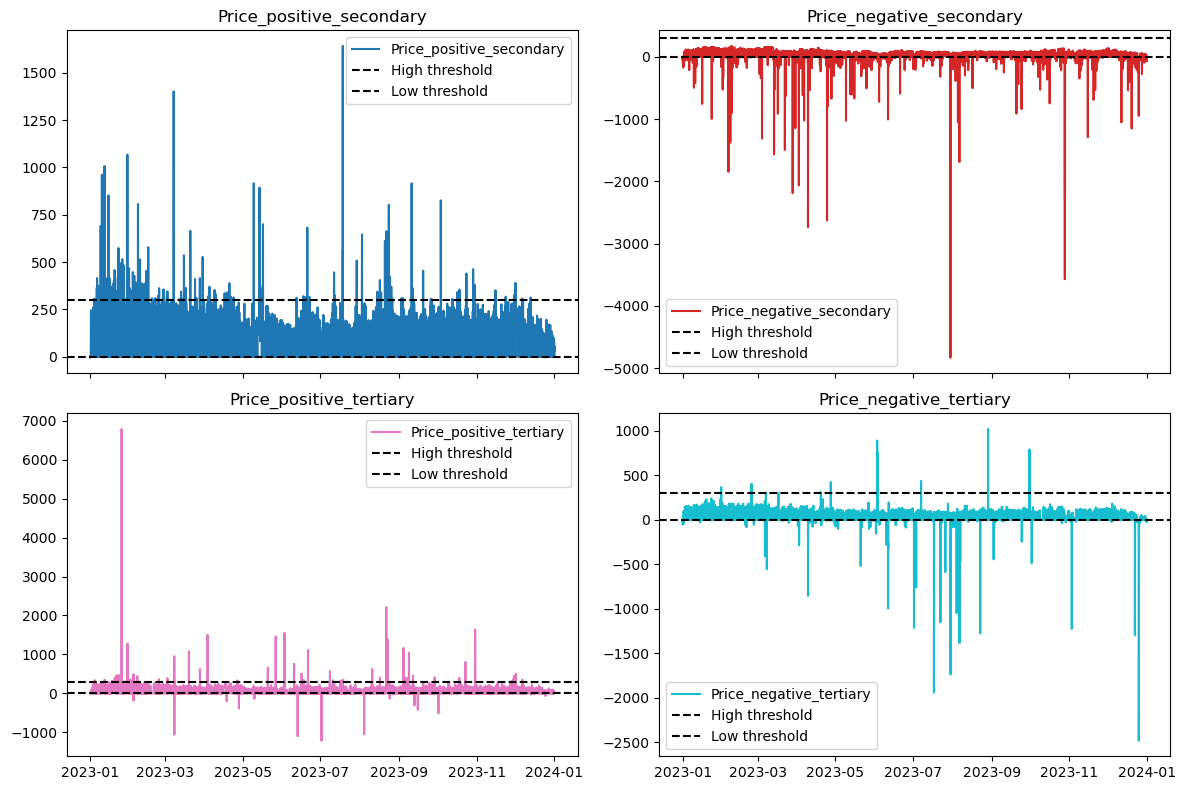

In [42]:
plot_targets_thresholds(data, targets=TARGETS,
                        method=LABEL_METHOD,
                        two_sided=TWO_SIDED,
                        percentile_high=P_HI,
                        percentile_low=P_LO,
                        roll_window=ROLL_WINDOW,
                        k=K_SIGMA)

(300, np.float64(0.0))
(300, np.float64(-1.360999999999999))
(300, np.float64(0.0))
(300, np.float64(0.0))


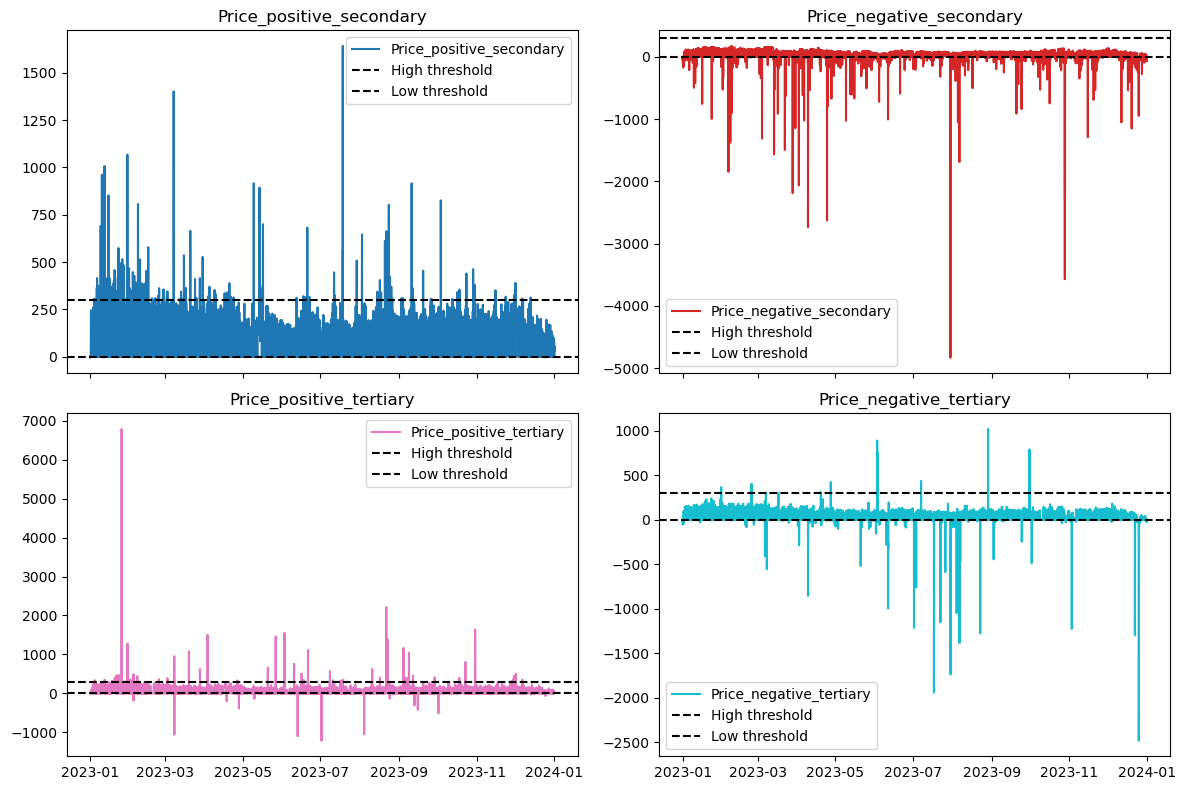

In [43]:
TH_BOTTOM = 0
TH_TOP = 10
plot_targets_thresholds(data, targets=TARGETS,
                        method=LABEL_METHOD,
                        two_sided=TWO_SIDED,
                        percentile_high=P_HI,
                        percentile_low=P_LO,
                        roll_window=ROLL_WINDOW,
                        k=K_SIGMA)

(2023-01-01 00:00:00    300.0
2023-01-01 01:00:00    300.0
2023-01-01 02:00:00    300.0
2023-01-01 03:00:00    300.0
2023-01-01 04:00:00    300.0
                       ...  
2023-12-31 19:00:00    300.0
2023-12-31 20:00:00    300.0
2023-12-31 21:00:00    300.0
2023-12-31 22:00:00    300.0
2023-12-31 23:00:00    300.0
Freq: h, Name: Price_positive_secondary, Length: 8760, dtype: float64, 2023-01-01 00:00:00    0.000
2023-01-01 01:00:00    0.000
2023-01-01 02:00:00   -3.416
2023-01-01 03:00:00   -2.989
2023-01-01 04:00:00   -4.468
                       ...  
2023-12-31 19:00:00    0.000
2023-12-31 20:00:00    0.000
2023-12-31 21:00:00    0.000
2023-12-31 22:00:00    0.000
2023-12-31 23:00:00    0.000
Freq: h, Name: Price_positive_secondary, Length: 8760, dtype: float64)
(2023-01-01 00:00:00    300.0
2023-01-01 01:00:00    300.0
2023-01-01 02:00:00    300.0
2023-01-01 03:00:00    300.0
2023-01-01 04:00:00    300.0
                       ...  
2023-12-31 19:00:00    300.0
2023-12-31 20:0

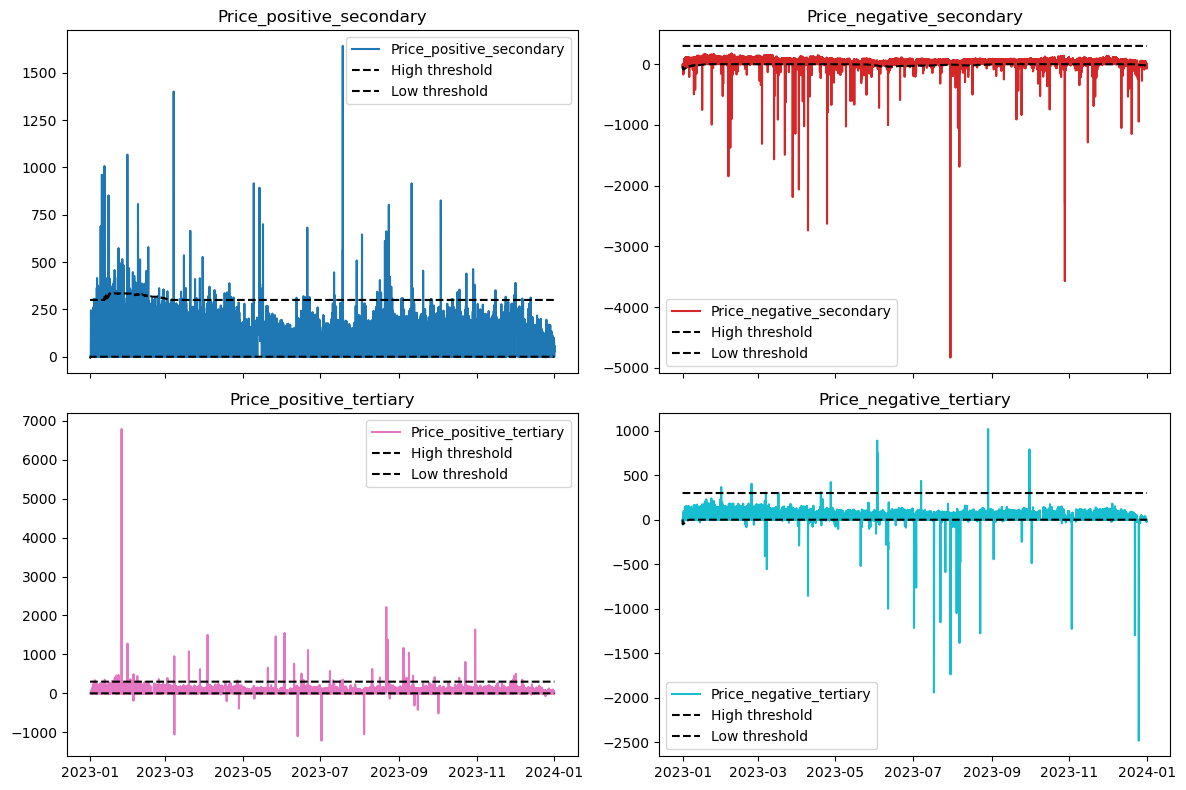

In [44]:
plot_targets_thresholds(data,
                        targets=TARGETS,
                        method="rolling",
                        two_sided=TWO_SIDED,
                        percentile_high=P_HI,
                        percentile_low=P_LO,
                        roll_window=24*7*7,
                        k=K_SIGMA,
                        figsize=(12, 8))

(2023-01-01 00:00:00    300.0
2023-01-01 01:00:00    300.0
2023-01-01 02:00:00    300.0
2023-01-01 03:00:00    300.0
2023-01-01 04:00:00    300.0
                       ...  
2023-12-31 19:00:00    300.0
2023-12-31 20:00:00    300.0
2023-12-31 21:00:00    300.0
2023-12-31 22:00:00    300.0
2023-12-31 23:00:00    300.0
Freq: h, Name: Price_positive_secondary, Length: 8760, dtype: float64, 2023-01-01 00:00:00    0.000000
2023-01-01 01:00:00    0.000000
2023-01-01 02:00:00   -3.888619
2023-01-01 03:00:00   -3.202500
2023-01-01 04:00:00   -4.205950
                         ...   
2023-12-31 19:00:00    0.000000
2023-12-31 20:00:00    0.000000
2023-12-31 21:00:00    0.000000
2023-12-31 22:00:00    0.000000
2023-12-31 23:00:00    0.000000
Freq: h, Name: Price_positive_secondary, Length: 8760, dtype: float64)
(2023-01-01 00:00:00    300.0
2023-01-01 01:00:00    300.0
2023-01-01 02:00:00    300.0
2023-01-01 03:00:00    300.0
2023-01-01 04:00:00    300.0
                       ...  
2023-12-31 

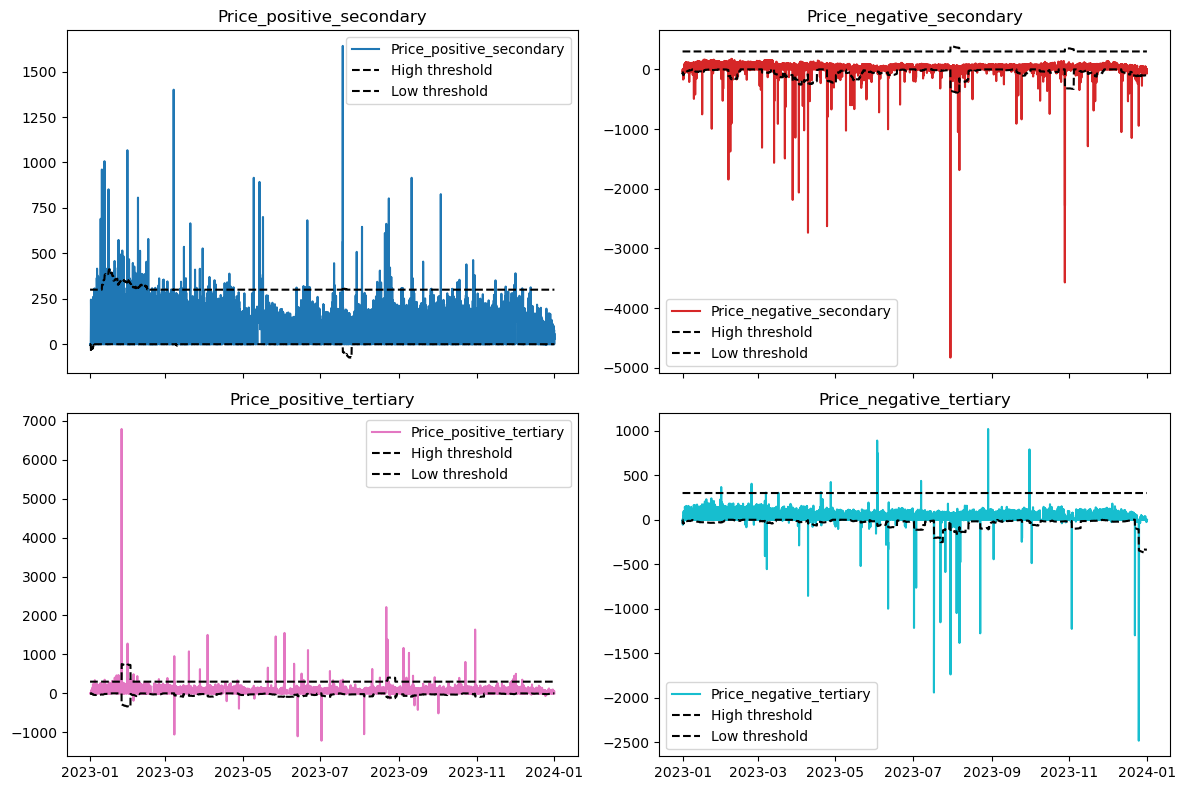

In [45]:
plot_targets_thresholds(data,
                        targets=TARGETS,
                        method="dynamic",
                        two_sided=TWO_SIDED,
                        percentile_high=P_HI,
                        percentile_low=P_LO,
                        roll_window=ROLL_WINDOW,
                        k=1,
                        figsize=(12, 8))

(2023-01-01 00:00:00    300.0
2023-01-01 01:00:00    300.0
2023-01-01 02:00:00    300.0
2023-01-01 03:00:00    300.0
2023-01-01 04:00:00    300.0
                       ...  
2023-12-31 19:00:00    300.0
2023-12-31 20:00:00    300.0
2023-12-31 21:00:00    300.0
2023-12-31 22:00:00    300.0
2023-12-31 23:00:00    300.0
Freq: h, Name: Price_positive_secondary, Length: 8760, dtype: float64, 2023-01-01 00:00:00    0.000000
2023-01-01 01:00:00    0.000000
2023-01-01 02:00:00   -3.888619
2023-01-01 03:00:00   -3.202500
2023-01-01 04:00:00   -4.205950
                         ...   
2023-12-31 19:00:00    0.000000
2023-12-31 20:00:00    0.000000
2023-12-31 21:00:00    0.000000
2023-12-31 22:00:00    0.000000
2023-12-31 23:00:00    0.000000
Freq: h, Name: Price_positive_secondary, Length: 8760, dtype: float64)
(2023-01-01 00:00:00    300.0
2023-01-01 01:00:00    300.0
2023-01-01 02:00:00    300.0
2023-01-01 03:00:00    300.0
2023-01-01 04:00:00    300.0
                       ...  
2023-12-31 

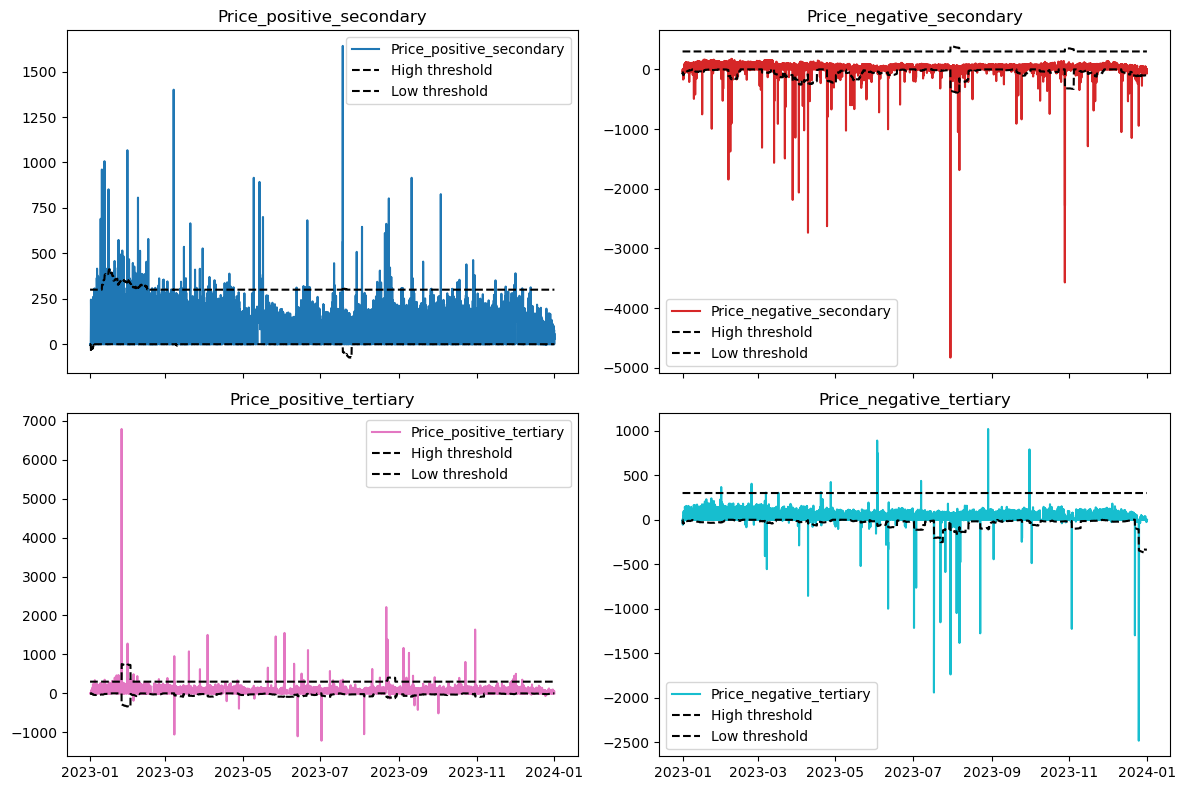

In [46]:
plot_targets_thresholds(data,
                        targets=TARGETS,
                        method="dynamic",
                        two_sided=TWO_SIDED,
                        percentile_high=95,
                        percentile_low=5,
                        roll_window=ROLL_WINDOW,
                        k=1,
                        figsize=(12, 8))

(2023-01-01 00:00:00    300.0
2023-01-01 01:00:00    300.0
2023-01-01 02:00:00    300.0
2023-01-01 03:00:00    300.0
2023-01-01 04:00:00    300.0
                       ...  
2023-12-31 19:00:00    300.0
2023-12-31 20:00:00    300.0
2023-12-31 21:00:00    300.0
2023-12-31 22:00:00    300.0
2023-12-31 23:00:00    300.0
Freq: h, Name: Price_positive_secondary, Length: 8760, dtype: float64, 2023-01-01 00:00:00     0.000000
2023-01-01 01:00:00     0.000000
2023-01-01 02:00:00    -6.353905
2023-01-01 03:00:00    -5.337500
2023-01-01 04:00:00    -6.637900
                         ...    
2023-12-31 19:00:00   -44.440923
2023-12-31 20:00:00   -44.982542
2023-12-31 21:00:00   -44.240594
2023-12-31 22:00:00   -43.492064
2023-12-31 23:00:00   -43.098218
Freq: h, Name: Price_positive_secondary, Length: 8760, dtype: float64)
(2023-01-01 00:00:00    300.0
2023-01-01 01:00:00    300.0
2023-01-01 02:00:00    300.0
2023-01-01 03:00:00    300.0
2023-01-01 04:00:00    300.0
                       ...  


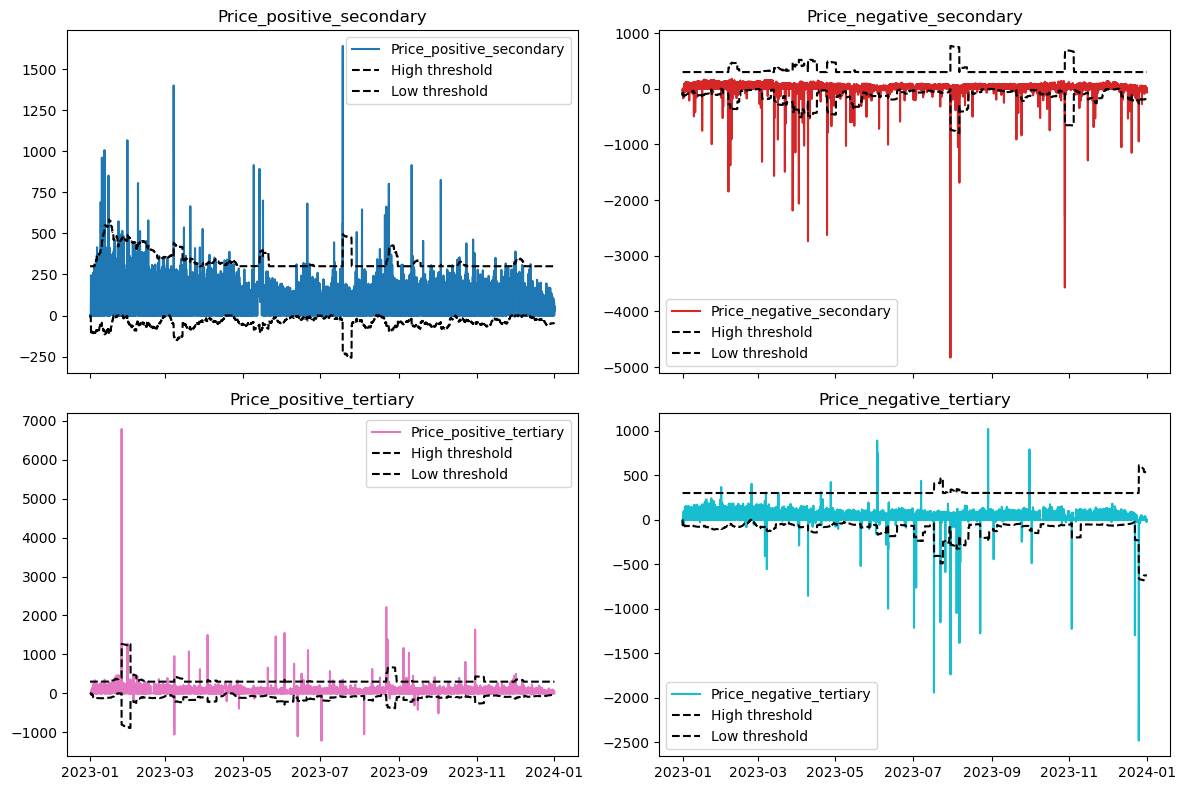

In [47]:
plot_targets_thresholds(data,
                        targets=TARGETS,
                        method="dynamic",
                        two_sided=TWO_SIDED,
                        percentile_high=P_HI,
                        percentile_low=P_LO,
                        roll_window=ROLL_WINDOW,
                        k=2,
                        figsize=(12, 8))

(2023-01-01 00:00:00    300.0
2023-01-01 01:00:00    300.0
2023-01-01 02:00:00    300.0
2023-01-01 03:00:00    300.0
2023-01-01 04:00:00    300.0
                       ...  
2023-12-31 19:00:00    300.0
2023-12-31 20:00:00    300.0
2023-12-31 21:00:00    300.0
2023-12-31 22:00:00    300.0
2023-12-31 23:00:00    300.0
Freq: h, Name: Price_positive_secondary, Length: 8760, dtype: float64, 2023-01-01 00:00:00     0.000000
2023-01-01 01:00:00     0.000000
2023-01-01 02:00:00    -6.353905
2023-01-01 03:00:00    -5.337500
2023-01-01 04:00:00    -6.637900
                         ...    
2023-12-31 19:00:00   -43.229019
2023-12-31 20:00:00   -43.485860
2023-12-31 21:00:00   -43.580704
2023-12-31 22:00:00   -43.419929
2023-12-31 23:00:00   -43.331810
Freq: h, Name: Price_positive_secondary, Length: 8760, dtype: float64)
(2023-01-01 00:00:00    300.0
2023-01-01 01:00:00    300.0
2023-01-01 02:00:00    300.0
2023-01-01 03:00:00    300.0
2023-01-01 04:00:00    300.0
                       ...  


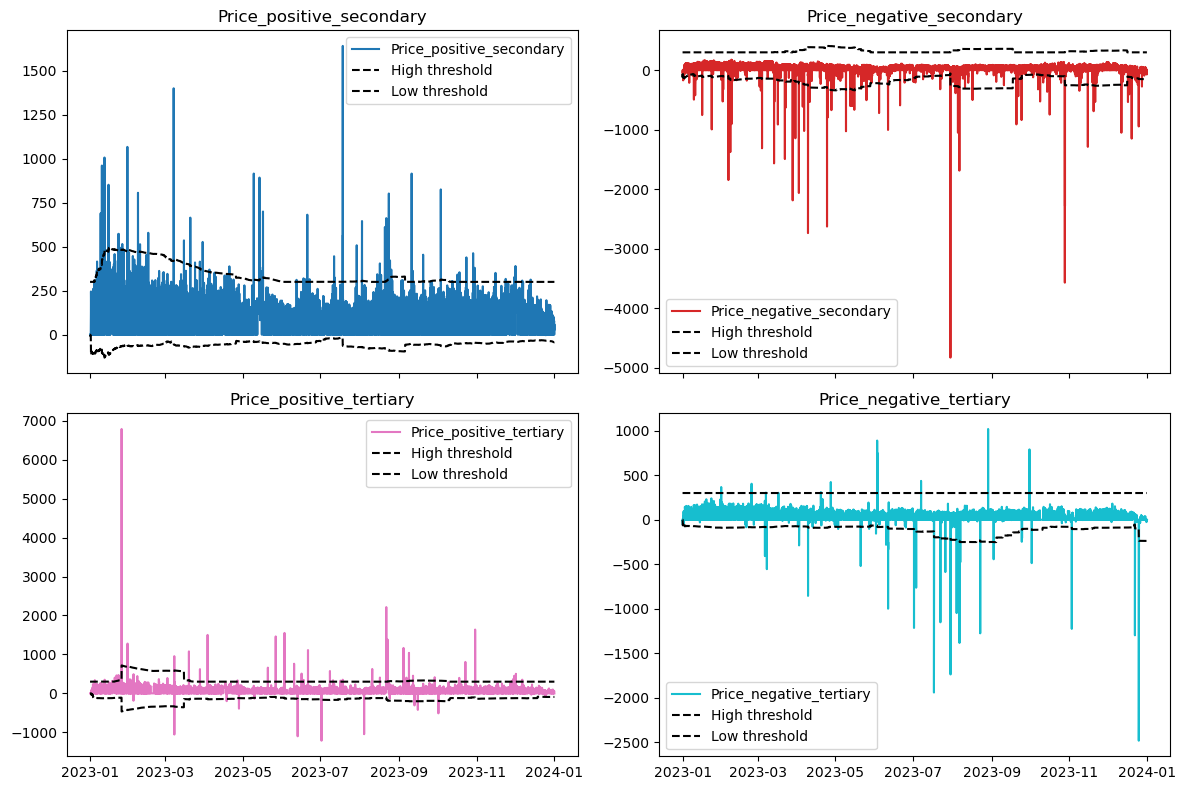

In [48]:
plot_targets_thresholds(data,
                        targets=TARGETS,
                        method="mixed",
                        two_sided=TWO_SIDED,
                        percentile_high=P_HI,
                        percentile_low=P_LO,
                        roll_window=24*7*7,
                        k=2,
                        figsize=(12, 8))

In [ ]:
hi, lo = make_labels(data['Price_positive_secondary'],
                     method=LABEL_METHOD,
                     two_sided=TWO_SIDED,
                     percentile_high=P_HI,
                     percentile_low=P_LO,
                     roll_window=ROLL_WINDOW,
                     k=K_SIGMA)
plot_with_threshold(data['Price_positive_secondary'], hi, lo, title="Price Positive Secondary with Thresholds")

ValueError: too many values to unpack (expected 2)

In [ ]:
def get_monthly_chunks_by_time(df_features, df_target):
    """
    Generate aligned chunks of features and target data by month.
    """
    feature_chunks = [chunk for _, chunk in df_features.groupby(pd.Grouper(freq='M'))]
    target_chunks = [chunk for _, chunk in df_target.groupby(pd.Grouper(freq='M'))]
    return feature_chunks, target_chunks

# def make_labels(df, method=LABEL_METHOD, window=ROLL_WINDOW, K=K_SIGMA):
        
#     data = df.copy()
#     # Compute global thresholds if fixed
#     if method == 'fixed':
#         global_hi = data[TARGETS].quantile(P_HI/100)
#         global_lo = data[TARGETS].quantile(P_LO/100)
#     # Compute rolling thresholds if needed
#     if method in ('rolling', 'dynamic'):
#         roll_hi = data[TARGETS].rolling(window, min_periods=1).quantile(P_HI/100)
#         roll_lo = data[TARGETS].rolling(window, min_periods=1).quantile(P_LO/100)
#         if method == 'dynamic':
#             roll_mean = data[TARGETS].rolling(window, min_periods=1).mean()
#             roll_std  = data[TARGETS].rolling(window, min_periods=1).std().fillna(0)
#     # Label each series
#     for col in TARGETS:
#         if method == 'fixed':
#             hi, lo = global_hi[col], global_lo[col]
#         elif method == 'rolling':
#             hi, lo = roll_hi[col], roll_lo[col]
#         else:  # dynamic
#             hi = roll_mean[col] + K * roll_std[col]
#             lo = roll_mean[col] - K * roll_std[col]
#         # Binary label for either-tail spike
#         data[f"{col}_spike"] = ((data[col] >= hi) | (data[col] <= lo)).astype(int)
#     return data

def plot_monthly_thresholds(data,
                            targets,
                            method='rolling',
                            two_sided=True,
                            percentile_high=P_HI,
                            percentile_low=P_LO,
                            window=168,
                            k=2,
                            figsize=(12, 8),
                            thresh_colors=('C1', 'C2'),
                            line_styles=('--', '--')):
    """
    For each calendar month in `data`, create a 2×2 subplot of the TARGET series
    with their high/low thresholds over that month, using make_labels directly.
    """
    df = data.copy()
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')

    # Loop months 1 through 12
    for month in range(1, 13):
        month_data = df[df.index.month == month]
        if month_data.empty:
            continue

        fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True)
        axes = axes.flatten()

        for ax, tgt in zip(axes, targets):
            series = month_data[tgt]

            # Compute thresholds via your make_labels function
            hi, lo = make_labels(series,
                                 method=method,
                                 two_sided=two_sided,
                                 percentile_high=percentile_high,
                                 percentile_low=percentile_low,
                                 roll_window=window,
                                 k=k)

            # Plot the actual series
            ax.plot(series.index, series, label=tgt)

            # Plot high threshold
            color_hi, color_lo = thresh_colors
            style_hi, style_lo = line_styles
            if isinstance(hi, (int, float)):
                ax.axhline(hi, linestyle=style_hi, color=color_hi, label='High thresh')
            else:
                ax.plot(hi.index, hi, linestyle=style_hi, color=color_hi, label='High thresh')

            # Plot low threshold if two_sided
            if two_sided and lo is not None:
                if isinstance(lo, (int, float)):
                    ax.axhline(lo, linestyle=style_lo, color=color_lo, label='Low thresh')
                else:
                    ax.plot(lo.index, lo, linestyle=style_lo, color=color_lo, label='Low thresh')

            ax.set_title(tgt)
            ax.legend(fontsize='small')

        fig.suptitle(f"Month {month}", fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

Fixed thresholds: hi=378.9125, lo=0.0
Fixed thresholds: hi=152.508, lo=-15.331500000000002
Fixed thresholds: hi=269.37660000000005, lo=0.0
Fixed thresholds: hi=164.927, lo=0.0


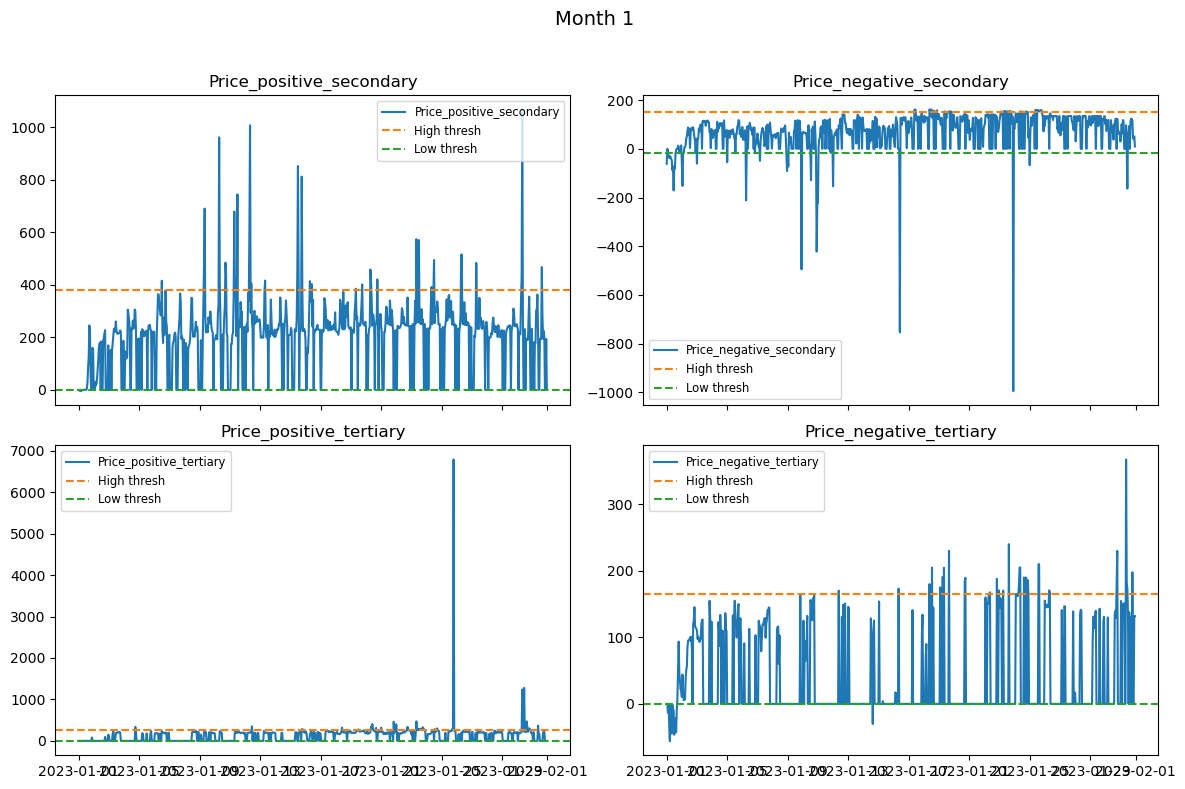

Fixed thresholds: hi=318.7699999999999, lo=0.0
Fixed thresholds: hi=127.71099999999996, lo=0.0
Fixed thresholds: hi=236.92549999999997, lo=0.0
Fixed thresholds: hi=158.29, lo=0.0


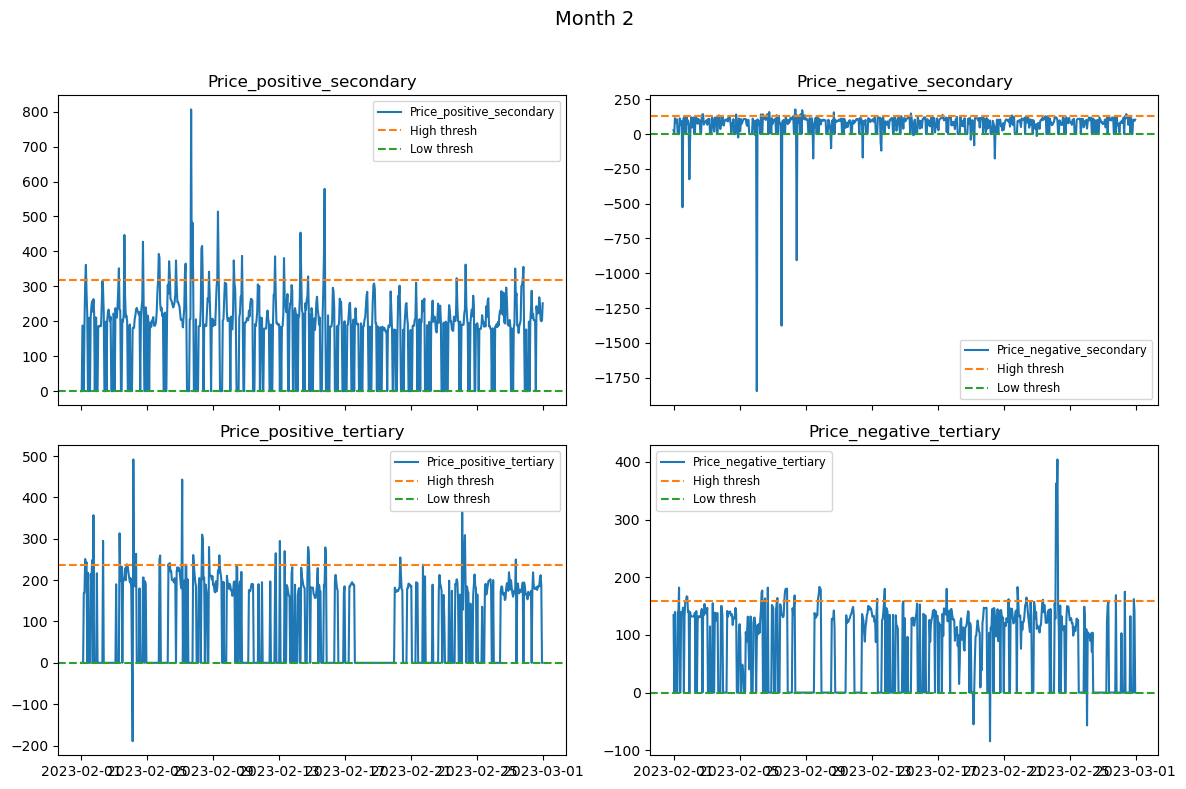

Fixed thresholds: hi=264.528, lo=0.0
Fixed thresholds: hi=150.0, lo=0.0
Fixed thresholds: hi=188.94125000000003, lo=0.0
Fixed thresholds: hi=140.07445, lo=0.0


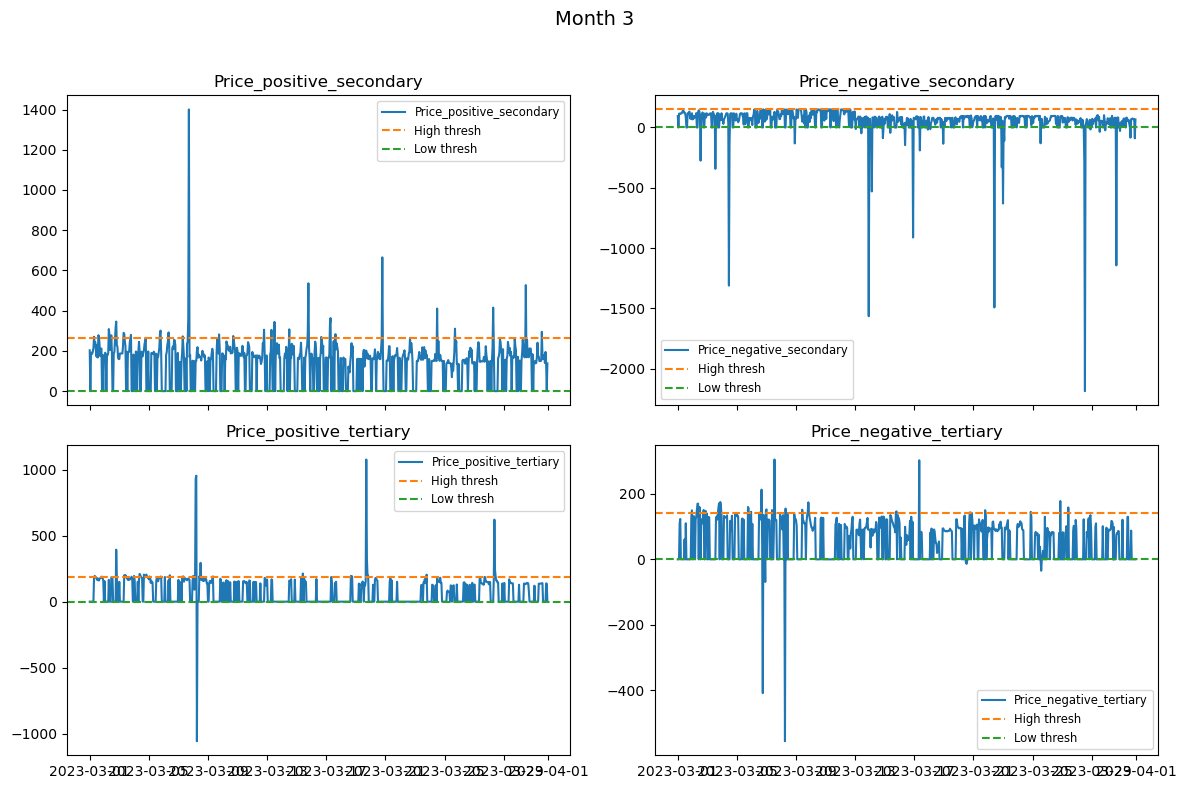

Fixed thresholds: hi=252.13149999999993, lo=0.0
Fixed thresholds: hi=108.1, lo=-63.175999999999995
Fixed thresholds: hi=178.51330000000002, lo=0.0
Fixed thresholds: hi=123.01649999999998, lo=0.0


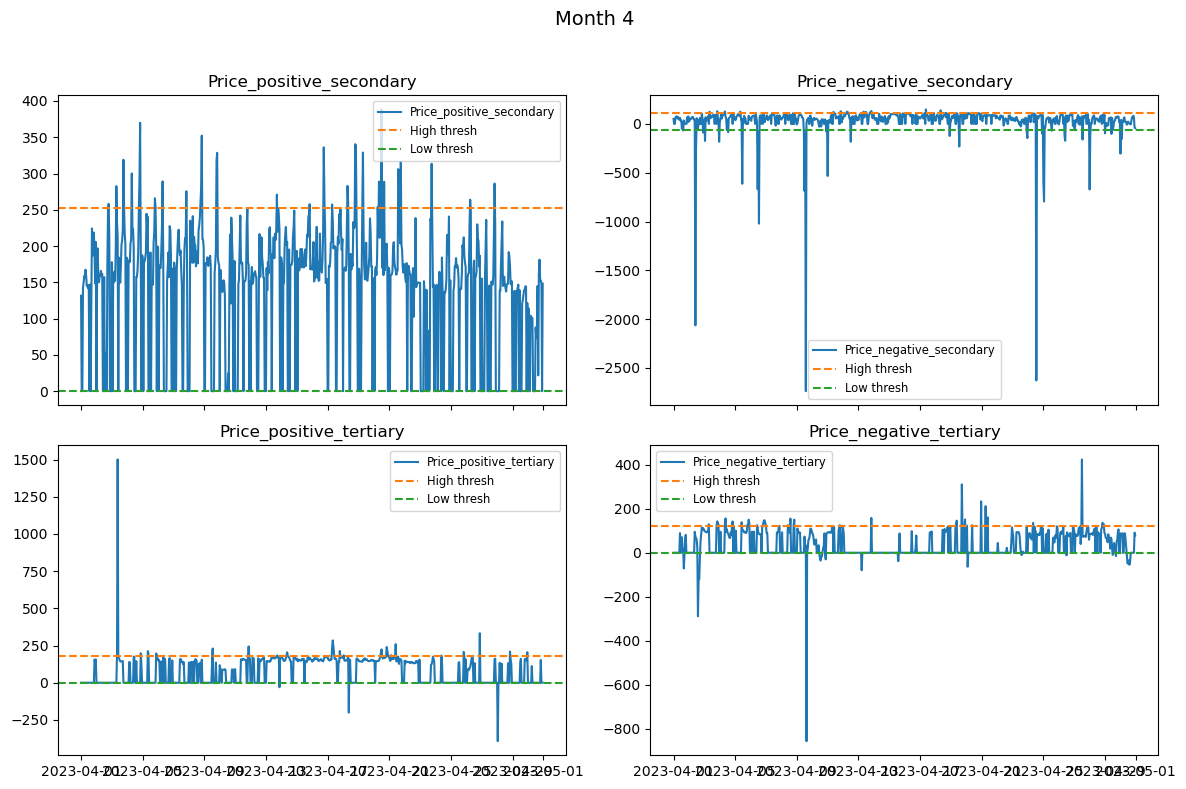

Fixed thresholds: hi=201.05400000000006, lo=0.0
Fixed thresholds: hi=86.8965, lo=-97.451
Fixed thresholds: hi=130.3862, lo=0.0
Fixed thresholds: hi=97.92750000000001, lo=0.0


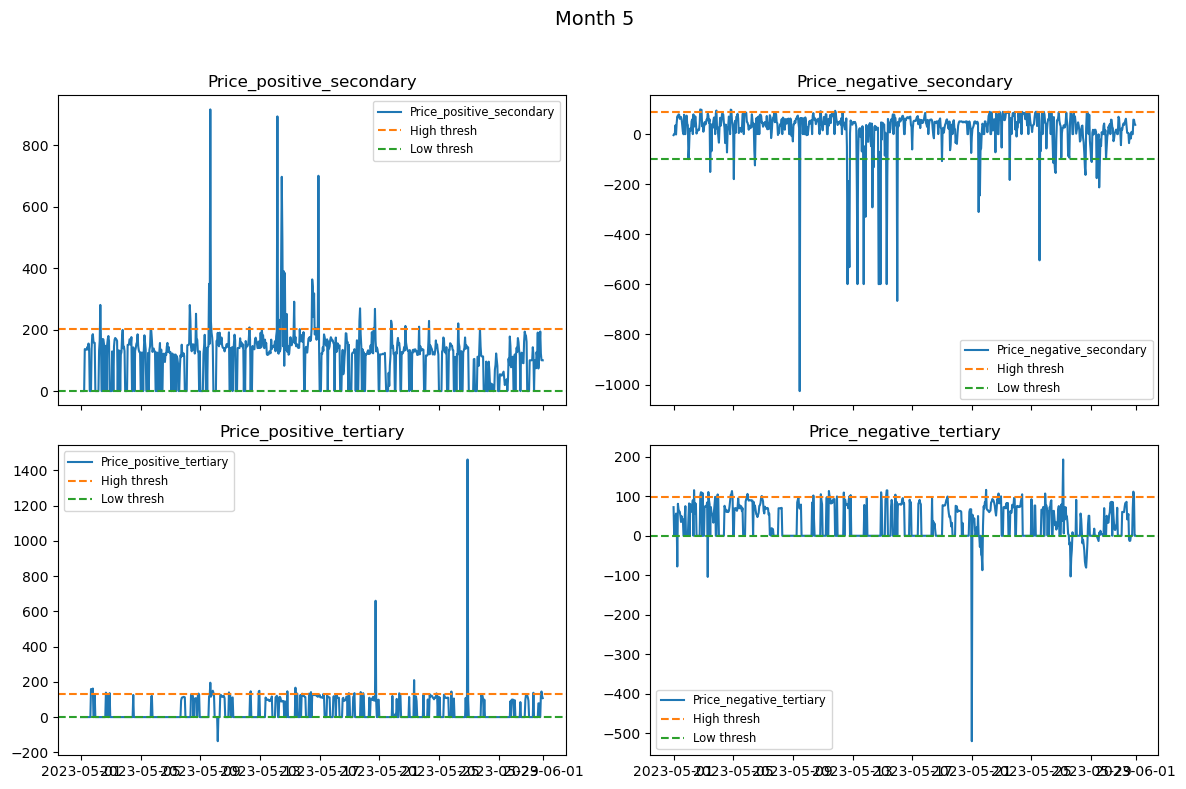

Fixed thresholds: hi=201.54849999999996, lo=0.0
Fixed thresholds: hi=85.8305, lo=-49.545
Fixed thresholds: hi=156.05999999999995, lo=0.0
Fixed thresholds: hi=105.01399999999998, lo=-1.4196999999999964


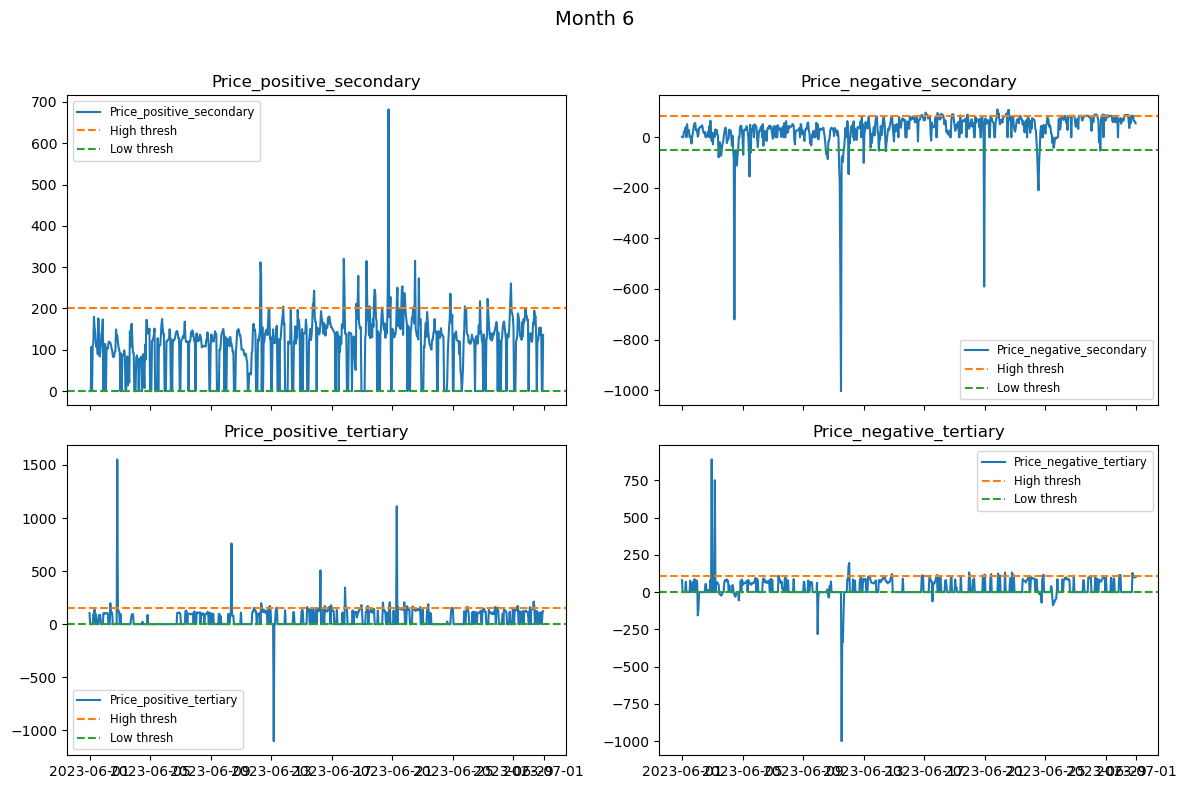

Fixed thresholds: hi=178.44600000000003, lo=0.0
Fixed thresholds: hi=80.58250000000001, lo=-47.594500000000004
Fixed thresholds: hi=145.09405000000004, lo=0.0
Fixed thresholds: hi=91.7427, lo=0.0


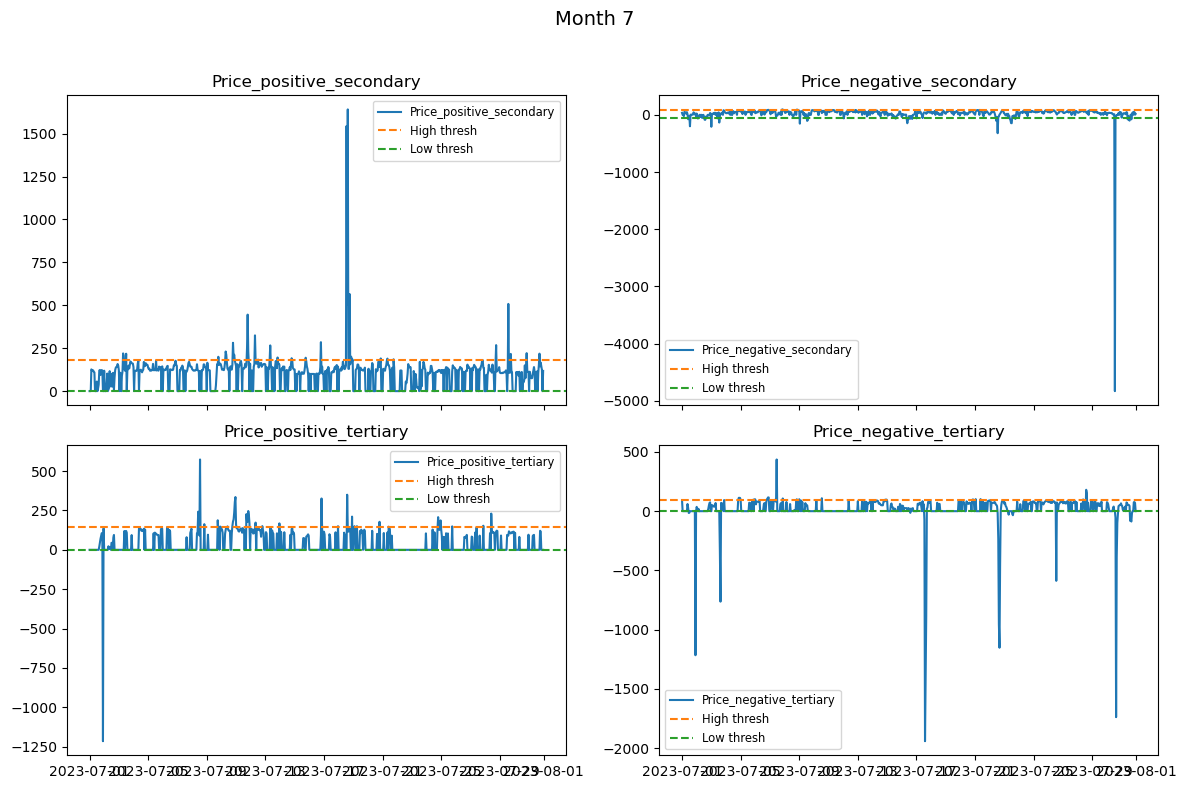

Fixed thresholds: hi=259.1795, lo=0.0
Fixed thresholds: hi=82.127, lo=-34.307500000000005
Fixed thresholds: hi=175.74635, lo=0.0
Fixed thresholds: hi=100.87335, lo=0.0


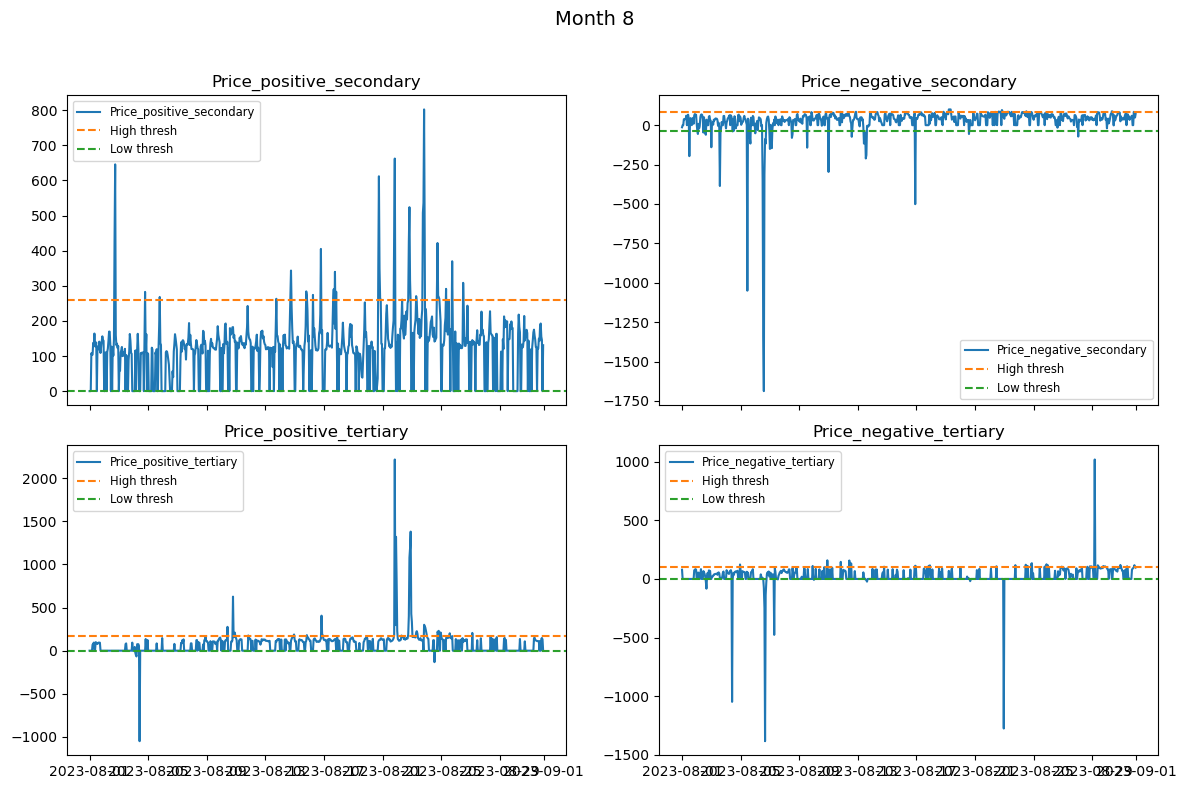

Fixed thresholds: hi=229.70399999999998, lo=0.0
Fixed thresholds: hi=82.722, lo=-29.1865
Fixed thresholds: hi=144.4646, lo=0.0
Fixed thresholds: hi=104.9705, lo=0.0


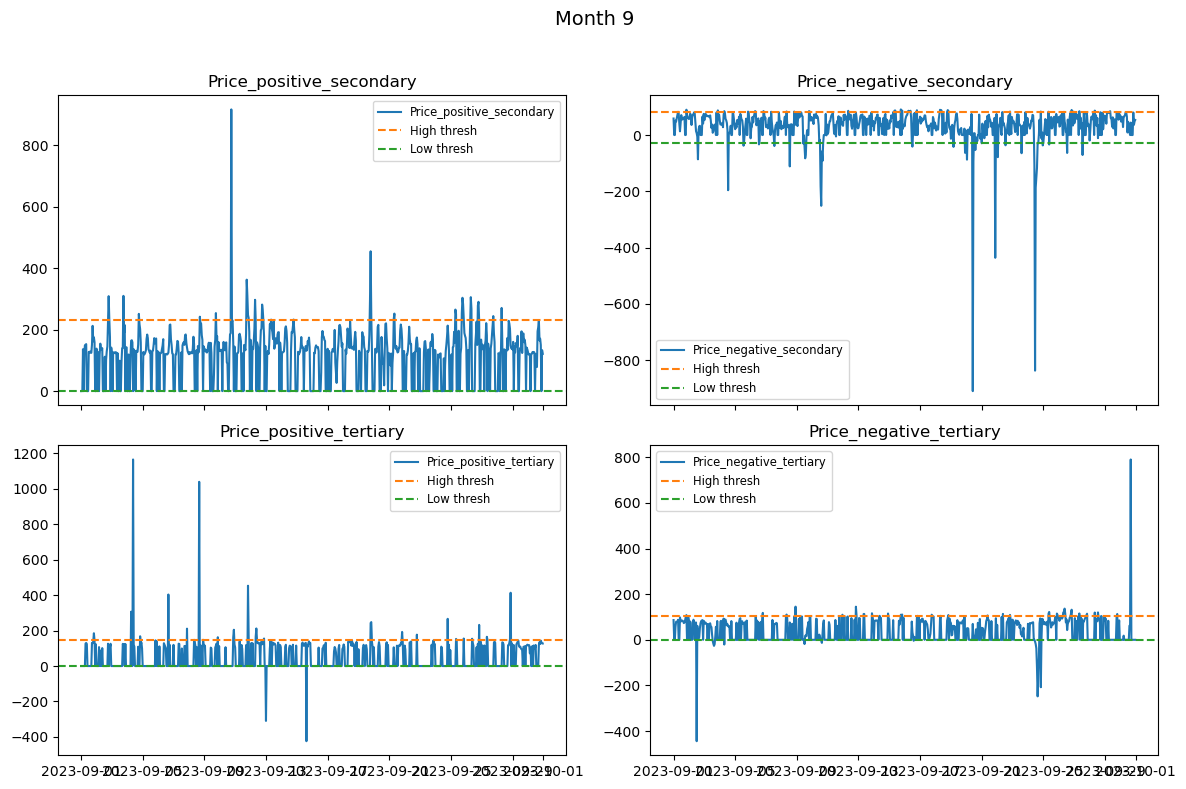

Fixed thresholds: hi=243.15400000000005, lo=0.0
Fixed thresholds: hi=105.0, lo=-23.555000000000003
Fixed thresholds: hi=179.80040000000002, lo=0.0
Fixed thresholds: hi=117.93070000000002, lo=0.0


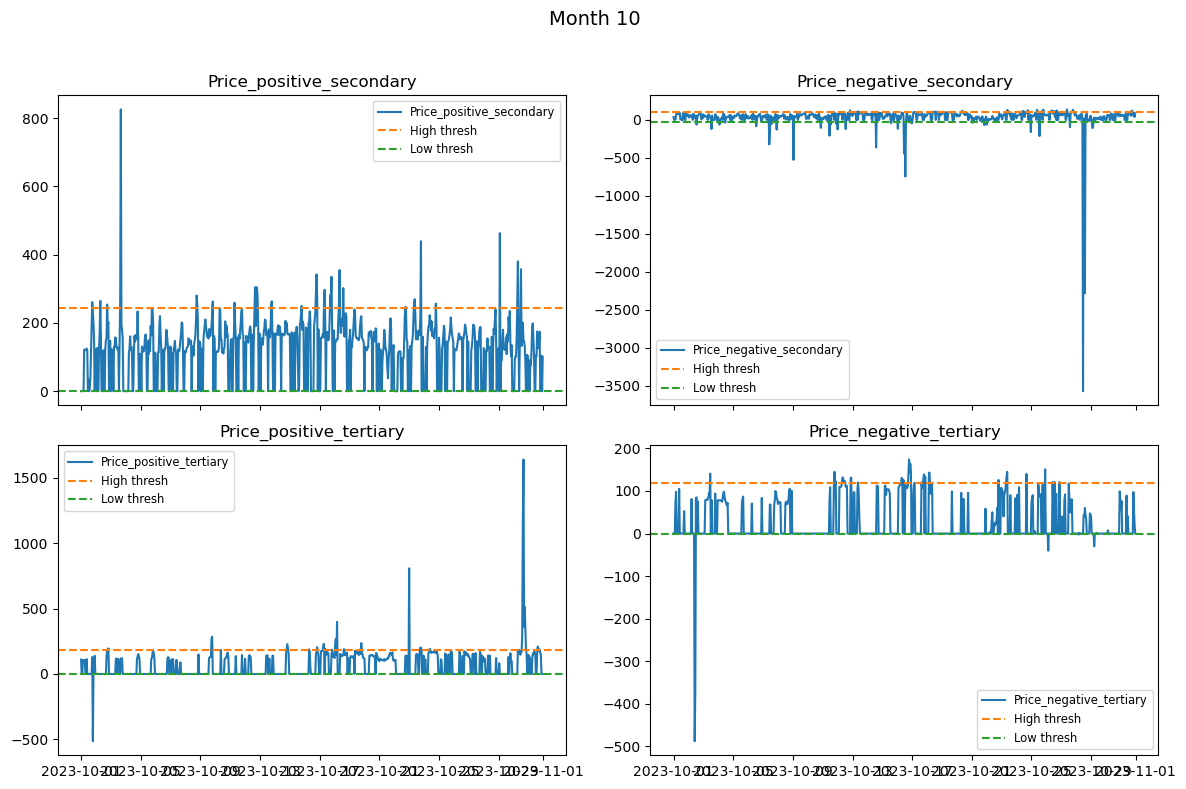

Fixed thresholds: hi=232.18799999999996, lo=0.0
Fixed thresholds: hi=99.57749999999999, lo=-45.443
Fixed thresholds: hi=185.15505, lo=0.0
Fixed thresholds: hi=109.00564999999999, lo=0.0


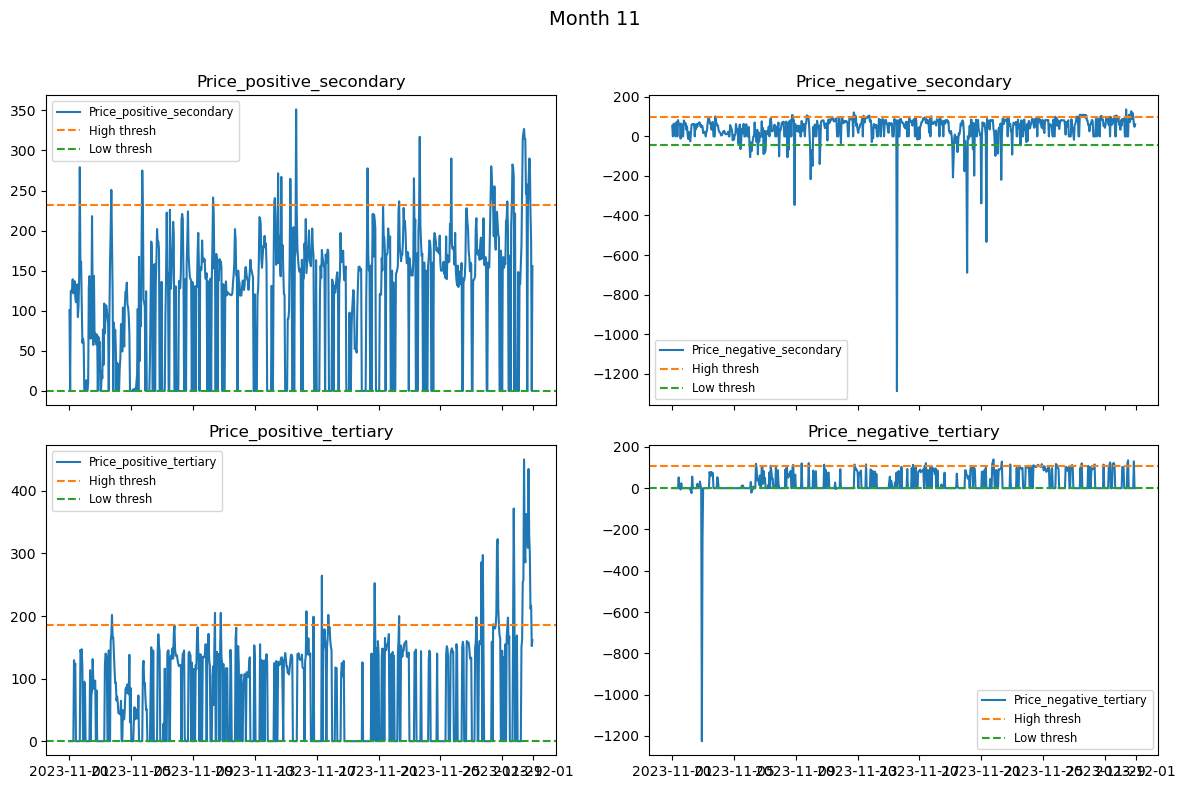

Fixed thresholds: hi=217.47600000000003, lo=0.0
Fixed thresholds: hi=103.27900000000004, lo=-50.202000000000005
Fixed thresholds: hi=158.37070000000003, lo=0.0
Fixed thresholds: hi=89.95005, lo=-11.833350000000001


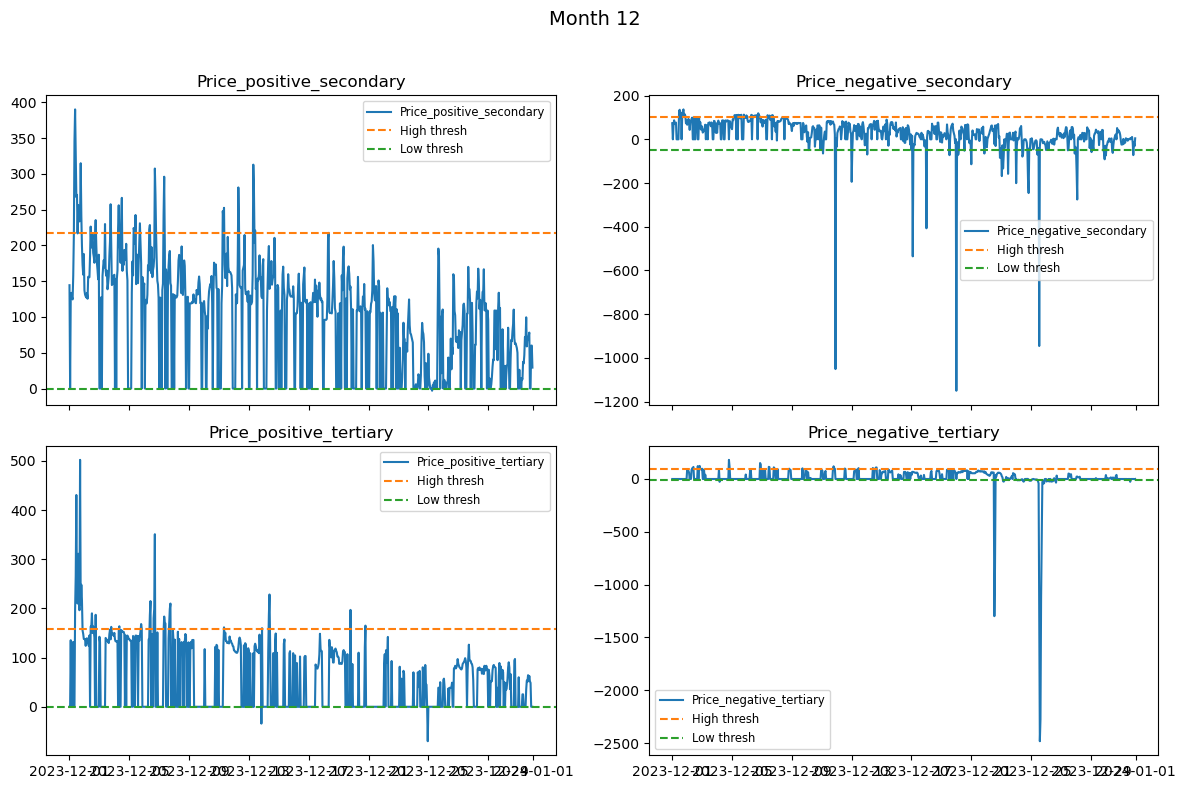

In [ ]:
ROLL_WINDOW = 24
P_HI = 95
P_LO = 5
plot_monthly_thresholds(data, method="fixed", targets=TARGETS, window=ROLL_WINDOW, k=1)